In [1]:
import sys
sys.path.append(r'..') 
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from model.model import MeNet
from model.Gdata import Data
from model.config import Config
from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import json

## This demo reproduces the results corresponding to Figure 1b, where $Z_{5}$ Oblique astigmatism is shown to provide superior multi-modal predictability when used as the modulated aberration.

In [2]:
def load_json_file(fpath):
    with open(fpath, 'r') as f:
        data = json.load(f)
    return data

In [3]:

file_path = '../DataSet/Demo1/astig5/'

data = load_json_file(str(file_path+'/config.json'))

print('Modulation:',data['modulate_aber'])
print('Initial Mode Ranges:',data['zernike_amplitude_ranges'])

Modulation: {'5': 0.2}
Initial Mode Ranges: {'5': 0.5}


## Import and set up the parameters

In [4]:
net_architecture = 'singleEncoder' 
c = Config(zernike_amplitude_ranges=data['zernike_amplitude_ranges'],
           modulate_aber=data['modulate_aber'],net_architecture = net_architecture,
           isMultiStream = 1,isRealTime = False,psf_na_detection=data['psf_na_detection'], 
           psf_units=tuple(data['psf_units']), psf_n=data['psf_n'], 
           psf_lam_detection=data['psf_lam_detection'],dataFile = data['dataFile'], 
           isRegular = data['isRegular'], regularValue = data['regularValue'])
#vars(c)

## Setup the model

In [5]:
model = MeNet(config=c, name='Initial_astig5', basedir='Demo1//')

input_shape (32, 32, 2)
output_size: 1


## Check/Set the model parameters and train the model

In [6]:
print(("MultiStream" if model.config.isMultiStream else "SingleStream"))
print("Net_architecture:",model.config.net_architecture)
print("Batch_size:",model.config.train_batch_size)
print("train_steps_per_epoch:",model.config.train_steps_per_epoch)
print("The number of predicted aberrations:",model.config.n_channel_out)
print("Range of predicted aberrations: ",model.config.zernike_amplitude_ranges)
print("Induced bias :",model.config.modulate_aber)
print("Net_architecture:",model.config.net_architecture)
print("Net_Learning_rate:",model.config.train_learning_rate)
print("RealTime:",model.config.isRealTime)
print("DataFile:",model.config.dataFile)

MultiStream
Net_architecture: singleEncoder
Batch_size: 32
train_steps_per_epoch: 1000
The number of predicted aberrations: 1
Range of predicted aberrations:  {'5': 0.5}
Induced bias : {'5': 0.2}
Net_architecture: singleEncoder
Net_Learning_rate: 0.0006
RealTime: False
DataFile: ../DataSet/Demo1/astig5/


In [7]:
model.config.train_learning_rate = 6e-4
model.config.train_steps_per_epoch = 100
model.config.train_batch_size = 32
model.config.train_n_val = 128


In [8]:
model.train(epochs=50)

c:\Users\ASUS\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
e:\Project\MeNet-AO\Demo\..\utils\psf.py:51: RuntimeWarning: invalid value encountered in sqrt
  H = np.sqrt(1. * self.n ** 2 - KR3 ** 2 * lam_detection ** 2)
c:\Users\ASUS\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


trainCheckpoint weights_best.h5
------------------------------
load train data...
------------------------------
e:\Project\MeNet-AO\Demo
(2400, 1)
load finished
Epoch 1/50
100/100 [==============================] - 7s 25ms/step - loss: 1.3301 - val_loss: 0.4973
Epoch 2/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0602 - val_loss: 0.1166
Epoch 3/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0418 - val_loss: 0.2244
Epoch 4/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0072 - val_loss: 0.1940
Epoch 5/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0052 - val_loss: 0.1266
Epoch 6/50
100/100 [==============================] - 2s 20ms/step - loss: 0.0049 - val_loss: 0.0769
Epoch 7/50
100/100 [==============================] - 2s 19ms/step - loss: 0.0062 - val_loss: 0.0295
Epoch 8/50
100/100 [==============================] - 2s 19ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 9/50
100/100 [==========

## load test dataset

In [9]:
test_data = np.load(model.config.dataFile+'data_test.npz')
X1_test = test_data['X1_test']
Y_test = test_data['Y_test']

In [10]:
X = X1_test
gt = Y_test

## Predict

In [11]:
zerns_noll = []
for k in model.config.zernike_amplitude_ranges.keys():
    zerns_noll.append(int(k))
pre = model.keras_model.predict(X)

## Results Evaluation

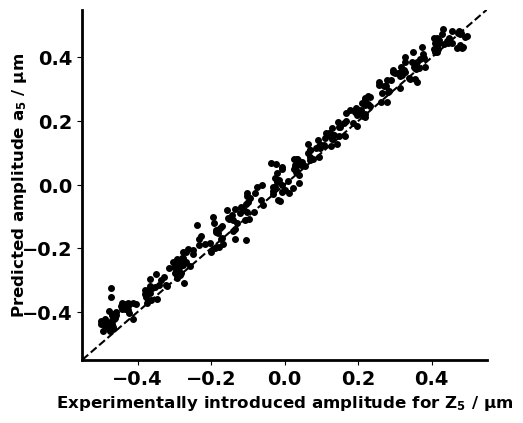

In [12]:
plt.figure(figsize=(24, 10),facecolor='w',edgecolor='w')
mode_num = 0
lower_limit,upper_limit = -0.5-0.05,0.5+0.05
for j in range(gt.shape[1]):
    plt.subplot(2,4,j+1)
    ax = plt.gca()
    for i in range(gt.shape[0]):
        ax.plot(gt[i][mode_num],pre[i][mode_num],"o",color='black', markersize=4)
    
    plt.xlabel(f'Experimentally introduced amplitude for $\mathbf{{Z_{{{zerns_noll[mode_num]}}}}}$ / $\mathbf{{\mu m}}$' , 
               size=12, fontweight='bold', labelpad=4)
    plt.ylabel(f'Predicted amplitude $\mathbf{{a_{{{zerns_noll[mode_num]}}}}}$ / $\mathbf{{\mu m}}$', 
               size=12, fontweight='bold', labelpad=-5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)  # x轴加粗
    ax.spines['left'].set_linewidth(2)    # y轴加粗

    plt.yticks(size=14,color="black", fontweight='bold')
    plt.xticks(size=14,color="black", fontweight='bold')
    plt.ylim(lower_limit,upper_limit)
    plt.xlim(lower_limit,upper_limit)

    XX = np.linspace(lower_limit, upper_limit, num=50)
    YY = 1 * XX
    ax.plot(XX, YY, ls="--", color = "k")

    mode_num = mode_num+1
    
